## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

import re
from collections import Counter
from wordcloud import WordCloud

import string
from string import punctuation
from textblob import TextBlob

from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, f1_score
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Staging

In [2]:
df = pd.read_csv("usaid_reddit_posts_New.csv", encoding='latin1')
df.head()

,Post ID,region,Text,title,Author,subreddit,score,Upvote Ratio,Number of Comments,Created At,url,Created Timestamp,comments,Unnamed: 13
0,1iis138,Africa,NaN,The Real Reason Musk is After USAID: They Help...,shake1010,MarchAgainstNazis,860,0.99,21,1738808995,https://i.redd.it/arjpjejvjfhe1.jpeg,2/6/2025 2:29,Welcome to /r/MarchAgainstNazis! \n\n**Please...,NaN
1,1iiontm,Africa,NaN,Usaid Delivering Foreign Aid to starving child...,trailer8k,Trailerclub,1,1,0,1738799255,https://v.redd.it/w5xmfqsvqehe1,2/5/2025 23:47,NaN,NaN
2,1iinl7c,Africa,How USAid has been spending taxpayer money\n\n...,How has USAID been spending taxpayer money?,ProtectedHologram,conspiracy,38,0.75,33,1738796394,https://www.reddit.com/r/conspiracy/comments/1...,2/5/2025 22:59,###[Meta] Sticky Comment\n\n[Rule 2](https://w...,NaN
3,1iini2u,Africa,NaN,Here's my list of exposed corrupt money launde...,Believe_143,LibTears,183,0.99,23,1738796165,https://i.redd.it/qt4m216qhehe1.jpeg,2/5/2025 22:56,And yet...hurricane victims in NC and fire vic...,NaN
4,1iijyzc,Africa,Source: https://x.com/kenklippenstein/status/1...,Some people say that USAIDâs aid is exclusiv...,SnooAdvice725,Lebanese,123,0.98,12,1738787376,https://i.redd.it/esuop84lrdhe1.jpeg,2/5/2025 20:29,So they're interfering in international politi...,NaN


## Data Understanding

In [3]:
# Merge the 'Text', 'title', and 'comments' columns into a new column called 'merged text'
df['merged text'] = df[['Text', 'title', 'comments']].apply(lambda x: ' '.join(x.dropna()), axis=1)

In [4]:
df.shape

(1299, 15)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1299 entries, 0 to 1298
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Post ID             1299 non-null   object
 1   region              1299 non-null   object
 2   Text                1018 non-null   object
 3   title               1298 non-null   object
 4   Author              1298 non-null   object
 5   subreddit           1298 non-null   object
 6   score               1298 non-null   object
 7   Upvote Ratio        1298 non-null   object
 8   Number of Comments  1298 non-null   object
 9   Created At          1298 non-null   object
 10  url                 1298 non-null   object
 11  Created Timestamp   1297 non-null   object
 12  comments            800 non-null    object
 13  Unnamed: 13         1 non-null      object
 14  merged text         1299 non-null   object
dtypes: object(15)
memory usage: 152.4+ KB


In [6]:
df.columns

Index(['Post ID', 'region', 'Text', 'title', 'Author', 'subreddit', 'score',
       'Upvote Ratio', 'Number of Comments', 'Created At', 'url',
       'Created Timestamp', 'comments', 'Unnamed: 13', 'merged text'],
      dtype='object')

In [7]:
df = df.drop(columns = ['Post ID', 'Text', 'title', 'Author', 'subreddit', 'score',
'Created At', 'url','Created Timestamp', 'comments', 'Unnamed: 13'])
df.head()

,region,Upvote Ratio,Number of Comments,merged text
0,Africa,0.99,21,The Real Reason Musk is After USAID: They Help...
1,Africa,1,0,Usaid Delivering Foreign Aid to starving child...
2,Africa,0.75,33,How USAid has been spending taxpayer money\n\n...
3,Africa,0.99,23,Here's my list of exposed corrupt money launde...
4,Africa,0.98,12,Source: https://x.com/kenklippenstein/status/1...


In [8]:
df.isnull().sum()

region                0
Upvote Ratio          1
Number of Comments    1
merged text           0
dtype: int64

In [9]:
df = df.dropna()
df.isnull().sum(), df.shape

(region                0
 Upvote Ratio          0
 Number of Comments    0
 merged text           0
 dtype: int64,
 (1298, 4))

In [10]:
df.duplicated().sum()

14

In [11]:
# Identify and display duplicated rows
duplicated_rows = df[df.duplicated()]
duplicated_rows.head()

,region,Upvote Ratio,Number of Comments,merged text
52,Africa,1,0,[Politics] - How Donald Trump's USAID pause th...
54,Africa,1,0,[Politics] - How Donald Trump's USAID pause th...
243,Middle East,1,0,"Trump proposes taking over the Gaza strip, bui..."
248,Middle East,1,0,"Trump proposes taking over the Gaza strip, bui..."
249,Middle East,1,0,"Trump proposes taking over the Gaza strip, bui..."


In [12]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [13]:
df.shape

(1284, 4)

## Sentiment Preprocessing

### Removing Tags

In [14]:
def remove_tags(raw_text):
    cleaned_text = re.sub(re.compile('<.*?>'), '', str(raw_text))
    return cleaned_text

In [15]:
df['cleaned_text'] = df['merged text'].apply(remove_tags)

In [16]:
df.head()

,region,Upvote Ratio,Number of Comments,merged text,cleaned_text
0,Africa,0.99,21,The Real Reason Musk is After USAID: They Help...,The Real Reason Musk is After USAID: They Help...
1,Africa,1,0,Usaid Delivering Foreign Aid to starving child...,Usaid Delivering Foreign Aid to starving child...
2,Africa,0.75,33,How USAid has been spending taxpayer money\n\n...,How USAid has been spending taxpayer money\n\n...
3,Africa,0.99,23,Here's my list of exposed corrupt money launde...,Here's my list of exposed corrupt money launde...
4,Africa,0.98,12,Source: https://x.com/kenklippenstein/status/1...,Source: https://x.com/kenklippenstein/status/1...


### Removing URLS

In [17]:
def remove_urls(text):
    pattern = re.compile(r'https?://\S+|www\.\S+|http?://\S+')
    return pattern.sub(r'', text)

In [18]:
df['cleaned_text'] = df['cleaned_text'].apply(remove_urls)

In [19]:
df.head()

,region,Upvote Ratio,Number of Comments,merged text,cleaned_text
0,Africa,0.99,21,The Real Reason Musk is After USAID: They Help...,The Real Reason Musk is After USAID: They Help...
1,Africa,1,0,Usaid Delivering Foreign Aid to starving child...,Usaid Delivering Foreign Aid to starving child...
2,Africa,0.75,33,How USAid has been spending taxpayer money\n\n...,How USAid has been spending taxpayer money\n\n...
3,Africa,0.99,23,Here's my list of exposed corrupt money launde...,Here's my list of exposed corrupt money launde...
4,Africa,0.98,12,Source: https://x.com/kenklippenstein/status/1...,Source: Some people say that USAIDâs aid is...


### Removing Unecessary Characters

In [20]:
def remove_unnecessary_characters(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', str(text))
    text = re.sub(r'\s+', ' ', str(text)).strip()
    return text

In [21]:
df['cleaned_text'] = df['cleaned_text'].apply(remove_unnecessary_characters)

In [22]:
df.head()

,region,Upvote Ratio,Number of Comments,merged text,cleaned_text
0,Africa,0.99,21,The Real Reason Musk is After USAID: They Help...,The Real Reason Musk is After USAID They Helpe...
1,Africa,1,0,Usaid Delivering Foreign Aid to starving child...,Usaid Delivering Foreign Aid to starving child...
2,Africa,0.75,33,How USAid has been spending taxpayer money\n\n...,How USAid has been spending taxpayer money 79 ...
3,Africa,0.99,23,Here's my list of exposed corrupt money launde...,Heres my list of exposed corrupt money launder...
4,Africa,0.98,12,Source: https://x.com/kenklippenstein/status/1...,Source Some people say that USAIDs aid is excl...


### Making all the Text in Lower case

In [23]:
df['cleaned_text'] = df['cleaned_text'].apply(lambda x:str(x).lower())

In [24]:
df.head(3)


,region,Upvote Ratio,Number of Comments,merged text,cleaned_text
0,Africa,0.99,21,The Real Reason Musk is After USAID: They Help...,the real reason musk is after usaid they helpe...
1,Africa,1,0,Usaid Delivering Foreign Aid to starving child...,usaid delivering foreign aid to starving child...
2,Africa,0.75,33,How USAid has been spending taxpayer money\n\n...,how usaid has been spending taxpayer money 79 ...


In [25]:
exclude = string.punctuation
exclude

def remove_punc1(text):
    return text.translate(str.maketrans('', '', exclude))

In [26]:
df['cleaned_text'] = df['cleaned_text'].apply(remove_punc1)

In [27]:
df.head()

,region,Upvote Ratio,Number of Comments,merged text,cleaned_text
0,Africa,0.99,21,The Real Reason Musk is After USAID: They Help...,the real reason musk is after usaid they helpe...
1,Africa,1,0,Usaid Delivering Foreign Aid to starving child...,usaid delivering foreign aid to starving child...
2,Africa,0.75,33,How USAid has been spending taxpayer money\n\n...,how usaid has been spending taxpayer money 79 ...
3,Africa,0.99,23,Here's my list of exposed corrupt money launde...,heres my list of exposed corrupt money launder...
4,Africa,0.98,12,Source: https://x.com/kenklippenstein/status/1...,source some people say that usaids aid is excl...


### Removing Stepwords From Dataset

In [28]:
sw_list = stopwords.words('english')

df['cleaned_text'] = df['cleaned_text'].apply(lambda x: [item for item in x.split() if item not in sw_list]).apply(lambda x:" ".join(x))

In [29]:
df.head()

,region,Upvote Ratio,Number of Comments,merged text,cleaned_text
0,Africa,0.99,21,The Real Reason Musk is After USAID: They Help...,real reason musk usaid helped end apartheid so...
1,Africa,1,0,Usaid Delivering Foreign Aid to starving child...,usaid delivering foreign aid starving children...
2,Africa,0.75,33,How USAid has been spending taxpayer money\n\n...,usaid spending taxpayer money 79 million teach...
3,Africa,0.99,23,Here's my list of exposed corrupt money launde...,heres list exposed corrupt money laundering fu...
4,Africa,0.98,12,Source: https://x.com/kenklippenstein/status/1...,source people say usaids aid exclusively human...


### Normalizing the Dataset

In [30]:
def normalize_text(text):
    if isinstance(text, str):
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
    else:
        text = str(text)
    return text
df['cleaned_text'] = df['cleaned_text'].apply(normalize_text)

In [31]:
df.head()

,region,Upvote Ratio,Number of Comments,merged text,cleaned_text
0,Africa,0.99,21,The Real Reason Musk is After USAID: They Help...,real reason musk usaid helped end apartheid so...
1,Africa,1,0,Usaid Delivering Foreign Aid to starving child...,usaid delivering foreign aid starving children...
2,Africa,0.75,33,How USAid has been spending taxpayer money\n\n...,usaid spending taxpayer money 79 million teach...
3,Africa,0.99,23,Here's my list of exposed corrupt money launde...,heres list exposed corrupt money laundering fu...
4,Africa,0.98,12,Source: https://x.com/kenklippenstein/status/1...,source people say usaids aid exclusively human...


### Sentence Polarity

In [32]:
def checkPostiveOrNegativeSentence(sentence):
    text = sentence.strip().lower()
    sentiment = TextBlob(text).sentiment
    if sentiment.polarity > 0:
        return "Positive 😊"
    elif sentiment.polarity < 0:
        return "Negative 😠"
    else:
        return "Neutral 😐"

In [33]:
df['Sentiment'] = df['cleaned_text'].apply(checkPostiveOrNegativeSentence)

In [34]:
df.head()

,region,Upvote Ratio,Number of Comments,merged text,cleaned_text,Sentiment
0,Africa,0.99,21,The Real Reason Musk is After USAID: They Help...,real reason musk usaid helped end apartheid so...,Positive 😊
1,Africa,1,0,Usaid Delivering Foreign Aid to starving child...,usaid delivering foreign aid starving children...,Negative 😠
2,Africa,0.75,33,How USAid has been spending taxpayer money\n\n...,usaid spending taxpayer money 79 million teach...,Positive 😊
3,Africa,0.99,23,Here's my list of exposed corrupt money launde...,heres list exposed corrupt money laundering fu...,Negative 😠
4,Africa,0.98,12,Source: https://x.com/kenklippenstein/status/1...,source people say usaids aid exclusively human...,Positive 😊


In [35]:
df.shape

(1284, 6)

## EDA

Class distribution:
Sentiment
Positive 😊    998
Negative 😠    187
Neutral 😐      99
Name: count, dtype: int64

Text length stats:
count     1284.000000
mean      4155.781153
std       5483.444872
min          0.000000
25%        456.750000
50%       1776.500000
75%       5162.250000
max      41026.000000
Name: text_length, dtype: float64


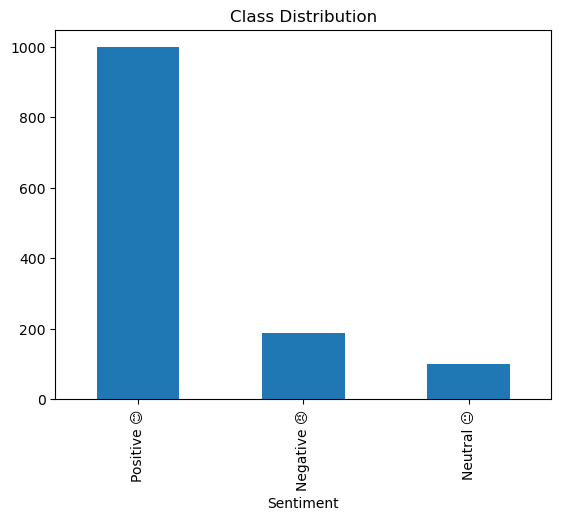

In [36]:
# Perform Exploratory Data Analysis (EDA)
def perform_eda(data):
    # Check class distribution
    print("Class distribution:")
    print(df['Sentiment'].value_counts())

    # Text length analysis
    df['text_length'] = df['cleaned_text'].apply(len)
    print("\nText length stats:")
    print(df['text_length'].describe())

    # Visualize class distribution
    df['Sentiment'].value_counts().plot(kind='bar', title="Class Distribution")
    plt.show()
perform_eda(df)

In [37]:
# Combine all texts based on sentiment
positive_text = df[df['Sentiment'] == 'Positive 😊']['cleaned_text'].str.cat(sep=' ')
negative_text = df[df['Sentiment'] == 'Negative 😠']['cleaned_text'].str.cat(sep=' ')
neutral_text = df[df['Sentiment'] == 'Neutral 😐']['cleaned_text'].str.cat(sep=' ')

In [38]:
# Function to get the most common words
def get_common_words(text):
    words = text.split()
    return Counter(words).most_common(10)

In [39]:
# Extract most common words
positive_common_words = get_common_words(positive_text)
negative_common_words = get_common_words(negative_text)
neutral_common_words = get_common_words(neutral_text)

print("Positive Common Words:", positive_common_words)
print("Negative Common Words:", negative_common_words)
print("Neutral Common Words:", neutral_common_words)

Positive Common Words: [('us', 3720), ('market', 2479), ('also', 2366), ('one', 2001), ('armenia', 1955), ('new', 1847), ('would', 1656), ('international', 1652), ('government', 1618), ('people', 1608)]
Negative Common Words: [('de', 335), ('us', 327), ('la', 198), ('que', 198), ('people', 184), ('said', 179), ('war', 167), ('like', 165), ('ukraine', 164), ('trump', 152)]
Neutral Common Words: [('usaid', 55), ('america', 23), ('asia', 19), ('east', 17), ('world', 16), ('africa', 16), ('south', 16), ('middle', 16), ('rworldnews', 12), ('us', 12)]


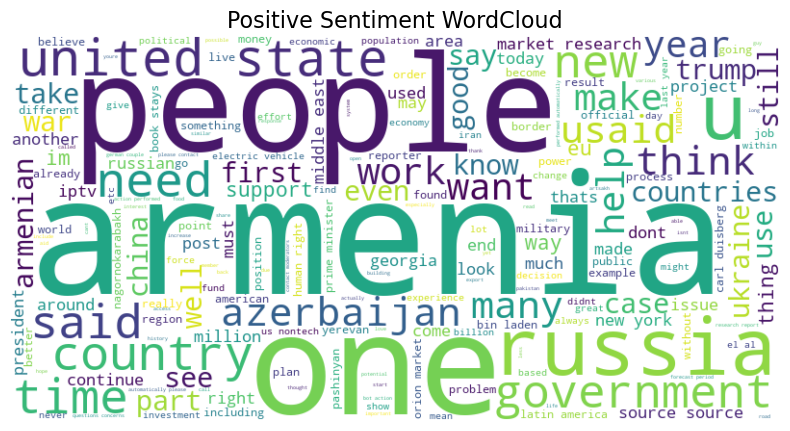

*********************************************************************************************


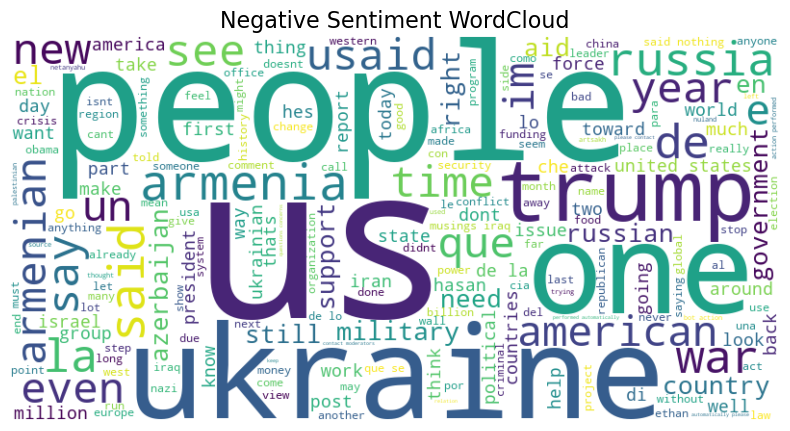

*********************************************************************************************


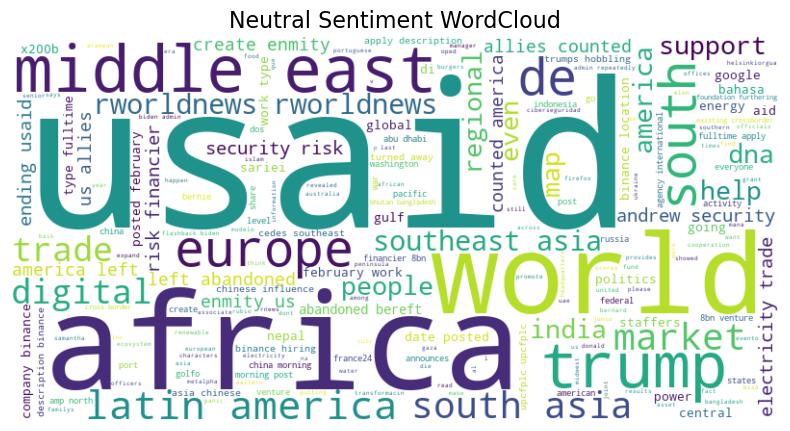

In [40]:
# Function to create WordCloud
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# Generate WordClouds for each sentiment
plot_wordcloud(positive_text, 'Positive Sentiment WordCloud')
print("*" * 93)
plot_wordcloud(negative_text, 'Negative Sentiment WordCloud')
print("*" * 93)
plot_wordcloud(neutral_text, 'Neutral Sentiment WordCloud')

1. `Positive Sentiment WordCloud`

- *Main Themes:* Words like Armenia, Russia, USAID, and people dominate the word cloud, suggesting that these topics were often mentioned positively.
- *Key Observations:* Positive contributions by USAID or international efforts involving countries like Armenia and Russia. Positive sentiment reflects optimism around government initiatives or partnerships.

2. `Negative Sentiment WordCloud`
- *Main Themes:* Words like Ukraine, US, Russia, Trump, people, and war are prominent, indicating a focus on conflict, dissatisfaction, or controversy.
- *Key Observations:* Negative discussions center on USAID's involvement in contentious regions, war-related topics, and public criticism of specific policies. Terms like Trump and military suggest negative views on leadership decisions and USAID withdrawal.

3. `Neutral Sentiment WordCloud`
- *Main Themes:* Words like world, USAID, Africa, and Middle East appear frequently, suggesting that neutral discussions revolve around general information or broad topics.
- *Key Observations:* Neutral sentiment represents factual reporting or balanced discussions about USAID’s role in various regions and sectors. Topics such as trade, digital, and energy hint at broader global or economic implications.

## Model Building

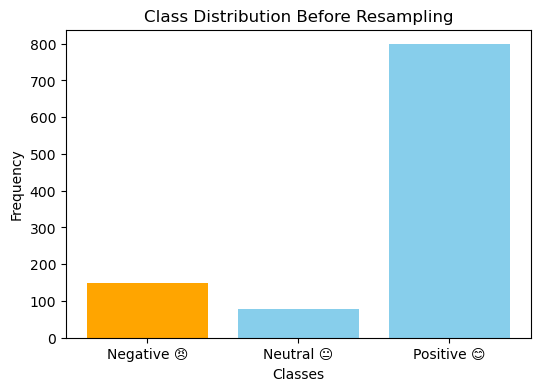

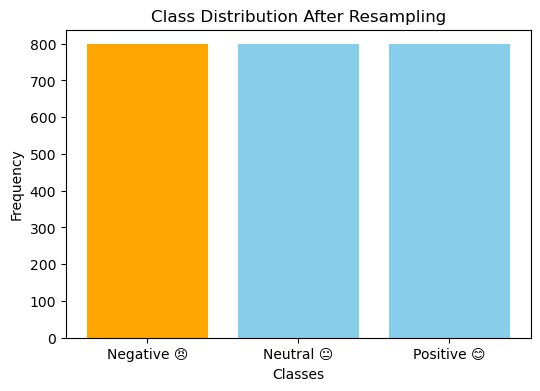

In [41]:
# Assuming your dataset has 'cleaned_text' and 'Sentiment' columns
X = df['cleaned_text']
y = df['Sentiment']

# Encode the labels (Positive, Negative -> 1, 0)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Convert training text to numerical features (e.g., TF-IDF)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Visualize class distribution before resampling
def plot_class_distribution(y_data, title, labels):
    counts = Counter(y_data)
    plt.figure(figsize=(6, 4))
    plt.bar(counts.keys(), counts.values(), color=['skyblue', 'orange'])
    plt.xticks(ticks=range(len(labels)), labels=labels)
    plt.title(title)
    plt.xlabel('Classes')
    plt.ylabel('Frequency')
    plt.show()

# Plot before resampling
plot_class_distribution(y_train, "Class Distribution Before Resampling", labels=label_encoder.classes_)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Plot after resampling
plot_class_distribution(y_train_resampled, "Class Distribution After Resampling", labels=label_encoder.classes_)

# Transform the test set using the same TF-IDF vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test)


### Model Building

### LSTM

In [42]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [43]:
# Custom Dataset for TF-IDF features
class TfidfDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        feature = torch.FloatTensor(self.features[idx])
        label = torch.tensor(self.labels[idx], dtype=torch.long)  # Return the label directly
        return feature, label

In [44]:
# Create dataset objects
train_dataset = TfidfDataset(X_train_resampled.toarray(), y_train_resampled)
test_dataset = TfidfDataset(X_test_tfidf.toarray(), y_test)

# DataLoader for batching the data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [45]:
# Define LSTM model with dropout for regularization
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.3):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM Layer with dropout
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)

        # Fully Connected Layer
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Apply dropout to the last hidden state
        out = self.dropout(out[:, -1, :])

        # Decode the hidden state of the last time step
        out = self.fc(out)
        return out

# Hyperparameters
input_size = X_train_resampled.shape[1]  # Number of TF-IDF features
hidden_size = 256
num_layers = 2
num_classes = 3  # Assuming binary sentiment classification
dropout_rate = 0.3

# Instantiate the model
model = LSTMClassifier(input_size, hidden_size, num_layers, num_classes, dropout_rate).to(device)

# Loss, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)  # AdamW with weight decay
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)  # Learning Rate Scheduling

In [46]:
# Early stopping
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopping = EarlyStopping(patience=3, min_delta=0.01)


In [47]:
# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    loop = tqdm(train_loader, leave=True)
    for features, labels in loop:
        features, labels = features.to(device), labels.to(device).long()
        optimizer.zero_grad()

        # Forward pass
        outputs = model(features.unsqueeze(1))  # Add sequence dimension for LSTM
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_description(f'Epoch {epoch + 1}')
        loop.set_postfix(loss=loss.item(), accuracy=100. * correct / total)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for features, labels in test_loader:  # Here we use test_loader as validation, adjust if you have a separate validation set
            features, labels = features.to(device), labels.to(device).long()
            outputs = model(features.unsqueeze(1))
            val_loss += criterion(outputs, labels).item()
    val_loss /= len(test_loader)

    # Learning Rate Scheduling
    scheduler.step(val_loss)

    # Early Stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch 5: 100%|████| 75/75 [00:06<00:00, 11.06it/s, accuracy=99.5, loss=0.00396]


Early stopping


In [48]:
# Evaluation (use your previous evaluation code here)
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for features, labels in test_loader:
        features = features.to(device)
        labels = labels.to(device).long()  # Ensure labels are in the correct format
        outputs = model(features.unsqueeze(1))
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())  # Ensure this is a 1D tensor
        all_probs.extend(probs.cpu().numpy())  # Assuming class 1 is the positive class

In [49]:
# Metrics
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8521400778210116


In [50]:
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"F1 score : {f1}")

F1 score : 0.8347378982659645


In [51]:
# AUC Score
auc = roc_auc_score(all_labels, all_probs, multi_class='ovr') 
print(f"AUC Score: {auc}")

AUC Score: 0.9439261868009371


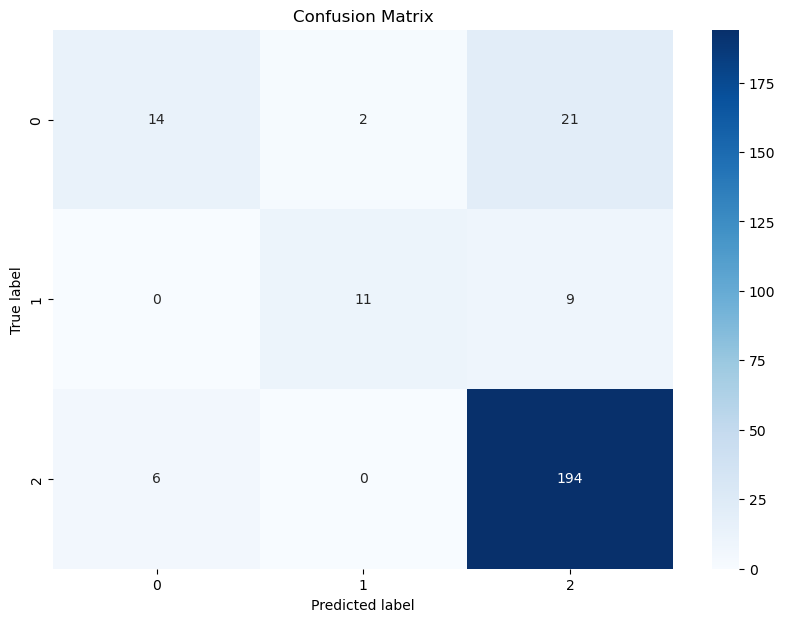

Classification Report:
              precision    recall  f1-score   support

  Positive 😊       0.70      0.38      0.49        37
  Negative 😠       0.85      0.55      0.67        20
   Neutral 😐       0.87      0.97      0.92       200

    accuracy                           0.85       257
   macro avg       0.80      0.63      0.69       257
weighted avg       0.84      0.85      0.83       257



In [52]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Positive 😊', 'Negative 😠','Neutral 😐']))

### CNN

In [53]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Custom Dataset for TF-IDF features
class TfidfDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        feature = torch.FloatTensor(self.features[idx])
        label = torch.tensor(self.labels[idx], dtype=torch.long)  
        return feature, label


# Create dataset objects
train_dataset = TfidfDataset(X_train_resampled.toarray(), y_train_resampled)
test_dataset = TfidfDataset(X_test_tfidf.toarray(), y_test)

# DataLoader for batching the data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define CNN model with dropout for regularization

class CNNClassifier(nn.Module):
    def __init__(self, input_size, num_classes, dropout_rate=0.3):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=256, kernel_size=3,padding=1)
        self.conv2 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3,padding=1)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, kernel_size=x.size(2))  # Global max pooling
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Hyperparameters
input_size = X_train_resampled.shape[1]  # Number of TF-IDF features
num_classes = 3  # Assuming binary sentiment classification
dropout_rate = 0.3

# Instantiate the model
model = CNNClassifier(input_size, num_classes, dropout_rate).to(device)

# Loss, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)  # AdamW with weight decay
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)  #

# Early stopping
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopping = EarlyStopping(patience=3, min_delta=0.01)

# Training loop
epochs = 5

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    loop = tqdm(train_loader, leave=True)
    for features, labels in loop:
        features, labels = features.to(device), labels.squeeze().to(device)

        # Forward pass
        outputs = model(features.unsqueeze(1).permute(0, 2, 1))  # Add channel dimension for CNN
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_description(f'Epoch {epoch + 1}')
        loop.set_postfix(loss=loss.item(), accuracy=100. * correct / total)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for features, labels in test_loader:  # Here we use test_loader as validation, adjust if you have a separate validation set
            features, labels = features.to(device), labels.to(device).long()
            outputs = model(features.unsqueeze(1).permute(0, 2, 1))
            val_loss += criterion(outputs, labels).item()
    val_loss /= len(test_loader)


    
    # Learning Rate Scheduling
    scheduler.step(val_loss)

    # Early Stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

Using device: cpu


Epoch 4: 100%|████| 75/75 [00:07<00:00,  9.40it/s, accuracy=99.6, loss=0.00049]


Early stopping


In [54]:
# Evaluation
model.eval()
all_preds_cnn = []
all_labels_cnn = []
all_probs_cnn = []

with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)  # No need to squeeze labels
        outputs = model(features.unsqueeze(1).permute(0, 2, 1))  # Add channel dimension
        probs = torch.nn.functional.softmax(outputs, dim=1)  # Softmax for probabilities
        _, predicted = torch.max(outputs.data, 1)  # Get predicted class indices

        all_preds_cnn.extend(predicted.cpu().numpy())  # Extend with batch predictions
        all_labels_cnn.extend(labels.cpu().numpy())  # Extend with batch labels
        all_probs_cnn.extend(probs.cpu().numpy())   # Assuming class 1 is the positive class


In [55]:
#accuracy
accuracy = accuracy_score(all_labels_cnn, all_preds_cnn)
print(f"Accuracy: {accuracy}")

Accuracy: 0.867704280155642


In [56]:
#f1 score
f1 = f1_score(all_labels_cnn, all_preds_cnn, average='weighted')
print(f"F1 score : {f1}")

F1 score : 0.870960319184657


In [57]:
# Compute AUC for multiclass (One-vs-Rest strategy)
auc = roc_auc_score(all_labels_cnn, all_probs_cnn, multi_class='ovr')
print(f"AUC Score: {auc}")

AUC Score: 0.9354892306757728


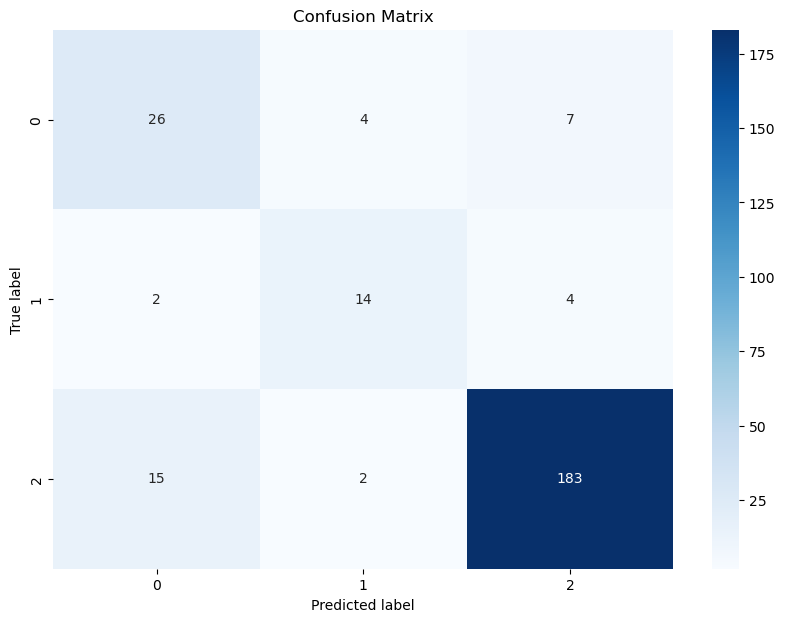

Classification Report:
              precision    recall  f1-score   support

  Positive 😊       0.60      0.70      0.65        37
  Negative 😠       0.70      0.70      0.70        20
   Neutral 😐       0.94      0.92      0.93       200

    accuracy                           0.87       257
   macro avg       0.75      0.77      0.76       257
weighted avg       0.88      0.87      0.87       257



In [58]:
#confusion matrix
cm = confusion_matrix(all_labels_cnn, all_preds_cnn)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#classifiaction report
print("Classification Report:")
print(classification_report(all_labels_cnn, all_preds_cnn, target_names=['Positive 😊', 'Negative 😠','Neutral 😐']))